# Jet tagging with transformers

This week we will build a transformer network for jet classification.

Some tips:
- the preprocessing will be similar as done for the graph net
- you should use the TransformerEncoder class in pytorch
- the output from this will be permutation equivariant, so you will need to aggregate the output to make it permutation invariant
- you should then feed the permutation invariant output to a dense net
- do not use very many encoder layers or a larger model dimension, this will be very heavy to run
- do some tests starting with small TransformerEncoders to find something suitable
- getting the best performance is not the important thing here, we just want to understand the network
- if you have questions/problems, check pytorch documentation and/or forums, or talk to each other
- if there's still problems, we can discuss during the tutorial

Some interesting papers:
- Attention Is All You Need
    - https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
- Symmetries, Safety, and Self-Supervision
    - https://arxiv.org/abs/2108.04253
- Particle Transformer for Jet Tagging
    - https://arxiv.org/abs/2202.03772

Outline:
- Imports and plotting set-up
- Building the dataset
    - Preprocessing
    - Dataloaders
- The self-attention mechanism
- Jets and self-attention
- The TransformerEncoder
- Building a Transformer classifier
- Optimising the Transformer classifier
- Study the results

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Loading the data

We'll be using the top-tagging data again, so let's just load what we saved out before.

In [3]:
X_train = np.load( "tutorial-3-data/TopTagging/x_train_short.npy")
y_train = np.load( "tutorial-3-data/TopTagging/y_train_short.npy")
X_test = np.load( "tutorial-3-data/TopTagging/x_test_short.npy")
y_test = np.load( "tutorial-3-data/TopTagging/y_test_short.npy")
X_val = np.load( "tutorial-3-data/TopTagging/x_val_short.npy")
y_val = np.load( "tutorial-3-data/TopTagging/y_val_short.npy")

## Building the dataset

For each jet we'll keep the $50$ constituents with the highest $p_T$, with each constituent consisting of $(p_T,\eta,\phi)$.
So each constituent in the jet has three features.

### Preprocessing

We still need to preprocess the jets in much the same way as we did for the CNN study.

In [4]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot

In [5]:
# function to convert the jet to a particle cloud
def constit_to_cloud( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt( pxs**2+pys**2 )
    
    print( "Calculating eta" )
    etas  = eta( pT, pzs )
    
    print( "Calculating phi" )
    phis  = phi( pxs, pys )
    
    print( "Calculating the mass" )
    E_tot = E.sum( axis=1 )
    px_tot = pxs.sum( axis=1 )
    py_tot = pys.sum( axis=1 )
    pz_tot = pzs.sum( axis=1 )
    j_mass = mass( E_tot, px_tot, py_tot, pz_tot )
    
    print( "Pre-shifting the phis" )
    phis = ( phis.T - phis[:,0] ).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    cloud = np.stack( [ pT/np.mean(pT), etas, phis ], axis=2 )
    
    return cloud

In [6]:
z_train = constit_to_cloud( X_train, 50, True, True, True )
z_val = constit_to_cloud( X_val, 50, True, True, True )
z_test = constit_to_cloud( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing


In [7]:
print( "Train data shape: " + str(z_train.shape) )
print( "Val data shape: " + str(z_val.shape) )
print( "Test data shape: " + str(z_test.shape) )

Train data shape: (30000, 50, 3)
Val data shape: (30000, 50, 3)
Test data shape: (30000, 50, 3)


In [8]:
z_train_p = torch.Tensor( z_train )
z_val_p = torch.Tensor( z_val )
z_test_p = torch.Tensor( z_test )
y_train_p = torch.Tensor( y_train )
y_val_p = torch.Tensor( y_val )
y_test_p = torch.Tensor( y_test )

### Dataloaders

In [9]:
class topcloud_dataset( Dataset ):
    
    def __init__( self, data, labels ):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [10]:
trn_dataset = topcloud_dataset( z_train_p, y_train_p.unsqueeze(-1) )
val_dataset = topcloud_dataset( z_val_p, y_val_p.unsqueeze(-1) )
tst_dataset = topcloud_dataset( z_test_p, y_test_p.unsqueeze(-1) )

In [11]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

## The self-attention mechanism

The self-attention mechanism takes $N$ input vectors and outputs $N$ vectors.  The output is permutation equivariant, i.e. there is a one-to-one map from each input vector to a single output vector, and if we were to change the ordering of the input vectors, the ordering of the output vectors would change in the same way.  The output vectors aim to provide a better representation of the input data by taking into account interactions between vectors in the input.  The dimension of the input and output vectors are in general different also.

In the 'Attention Is All You Need' paper they describe attention as:

"An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key."

### Scaled dot-product attention

There are many forms of attention, we use the scaled dot-product attention, defined as:

$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$

where $Q$, $K$, and $V$ are the query, key, and value vectors.
The query and key vectors have dimension $d_k$ and the value vectors have dimension $d_v$.

The self-attention mechanism is built using three matrices:
- Query matrix
- Key matrix
- Value matrix

They all have dimension ``input_dim`` x ``embed_dim``.
In the transformer the parameters of these matrices are learned through back-propagation.

### Multi-headed self-attention

The self-attention mechanism we just described has a single head, i.e. one set of query/key/value matrices to project from the input to the output.  Multi-headed self-attention does the same projection but with multiple sets of query/key/value matrices.  Let's say the embedding dimension we want is 20, and we choose 4 heads.  This means we will have 4 attention-mechanisms, each projecting the input data to a 5 dimensional output.  These outputs are then appended together to produce the 20 dimensional embedding.  When using multi-headed self-attention we need to ensure that the embedding dimension is exactly divisible by the number of heads.

## Jets and self-attention

Jets will have a data dimension of ``noc``x$3$, where ``noc`` is just the number of constituents.  So let's say $50$x$3$ if we restrict to the 50 hardest constituents.

This means that the input dimension is $3$.

### An example

Let's create a fake jet with 10 constituents.

In [25]:
jet = torch.rand( (10,3) )

In [336]:
jet

tensor([[0.8299, 0.0349, 0.8124],
        [0.9867, 0.4401, 0.8742],
        [0.8911, 0.4684, 0.1993],
        [0.2100, 0.1716, 0.0045],
        [0.5461, 0.8853, 0.8914],
        [0.3362, 0.2971, 0.1099],
        [0.3754, 0.3450, 0.5542],
        [0.5595, 0.5792, 0.0952],
        [0.4977, 0.1773, 0.2465],
        [0.5894, 0.4989, 0.0365]])

The input dim is obviously 3, and we can define the embed_dim to be whatever we like.

In [337]:
input_dim = 3
embed_dim = 5

In practice the query, key, and value matrices consist of learnable parameters that are optimised during training.  But to demonstrate the self-attention mechanism here we will just initialise them randomly.

In [338]:
w_query = torch.rand( ( input_dim, embed_dim ) )
w_key = torch.rand( ( input_dim, embed_dim ) )
w_value = torch.rand( ( input_dim, embed_dim ) )

From these matrices we then contruct the queries, keys, and values.

In [339]:
queries = torch.matmul( jet, w_query )
keys = torch.matmul( jet, w_key )
values = torch.matmul( jet, w_value )

And check it has the correct shape.

In [340]:
queries.shape

torch.Size([10, 5])

We need the length of the queries vector for the computation, so we save it below.

In [341]:
dk = torch.Tensor( [queries.shape[1]] )

We then compute the query-key matrix multiplication.

In [342]:
qkt = torch.matmul( queries, keys.t() )

In [343]:
qkt.shape

torch.Size([10, 10])

The attention weights are just the softmax over this matrix, divided by the square root of the query dimension.

In [344]:
attn = torch.softmax( torch.div( qkt, torch.sqrt(dk) ), dim=-1 )

The shape here is 10 by 10, which makes sense because this matrix tells us how much attention each input pays to every other input.  Since we have 10 inputs this should make it 10 by 10.

In [345]:
attn.shape

torch.Size([10, 10])

The output of the self-attention mechanism is then just the attention matrix multiplied by the values.

In [352]:
out = torch.matmul( attn, values )

In [353]:
out

tensor([[1.0485, 0.7042, 0.8840, 0.8069, 1.0408],
        [1.1261, 0.7454, 0.9307, 0.8729, 1.1141],
        [1.0703, 0.7153, 0.8949, 0.8275, 1.0621],
        [0.9341, 0.6419, 0.8117, 0.7115, 0.9328],
        [1.1415, 0.7525, 0.9410, 0.8824, 1.1261],
        [0.9758, 0.6643, 0.8379, 0.7459, 0.9718],
        [1.0230, 0.6897, 0.8686, 0.7836, 1.0154],
        [1.0417, 0.6994, 0.8779, 0.8017, 1.0340],
        [0.9873, 0.6707, 0.8452, 0.7559, 0.9830],
        [1.0287, 0.6925, 0.8697, 0.7912, 1.0220]])

In [354]:
out.shape

torch.Size([10, 5])

This shape makes sense.  We started with a 10 by 3 input, projecting the input dimension to the embedding dimension.

This output is also permutation equivariant, i.e. if we change the ordering of the inputs (the constituents in the jet) then the same change will be reflected in the output.

To obtain a permutation invariant output we would simply need to sum over dimension zero here.

In [350]:
inv_out = torch.sum( out, dim=0 )

In [351]:
inv_out.shape

torch.Size([5])

## The transformer encoder

The first layer of a transformer encoder is the embedding layer, it is simply a linear projection of each input to a vector of length ``d_model``.
So if we have a jet with 50 constituents and $(p_t,\eta,\phi)$ values for each constituent, the embedding layer would project each constituent separately to a vector of length ``d_model``, so that the output of this layer has dimensions 50 by ``d_model``.
Note that it is the same linear neural network applied to each constituent in the jet.

After the embedding the data is passed through a TransformerEncoderLayer, defined in the torch.nn module.

In [355]:
from torch.nn import TransformerEncoderLayer as TEL

The documentation tells us:

TransformerEncoderLayer is made up of self-attn and feedforward network. This standard encoder layer is based on the paper “Attention Is All You Need”. Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information Processing Systems, pages 6000-6010. Users may modify or implement in a different way during application.

This is kind of vague, but after looking at the code we see that there is a multi-headed self-attention layer followed by a dense neural network.  
The dense neural network acts individually on each constituent in the jet and has three layers with dimensions ``(d_model, dim_feedforward, d_model)``.
Note also that the TransformerEncoder assumes that the input dimension is the same as the embedding dimension, we'll deal with this later using an embedding layer.

The parameters we need to initialise a layer are as follows:

- d_model – the number of expected features in the input (required).

- nhead – the number of heads in the multiheadattention models (required).

- dim_feedforward – the dimension of the feedforward network model (default=2048).

- dropout – the dropout value (default=0.1).

- activation – the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu

- layer_norm_eps – the eps value in layer normalization components (default=1e-5).

- batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False (seq, batch, feature).

- norm_first – if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

Let's test it:

In [482]:
encoder_layer = TEL( d_model=120, nhead=4, batch_first=True, dropout=0.0 )
src = torch.rand( 10, 50, 120 )
out = encoder_layer( src )

This means we have a batch of 10 jets with 50 constituents each and 120 features per jet.

In [483]:
out.shape

torch.Size([10, 50, 120])

We can check the permutation equivariance of the output by permuting the constituents in the input and checking the output.

Permuting the input:

In [499]:
src1 = src.detach().clone()

In [485]:
src1[:,0] = src[:,1].detach().clone()
src1[:,1] = src[:,0].detach().clone()

Getting the output and permuting it:

In [486]:
out1 = encoder_layer( src1 )

In [487]:
out1_perm = out1.detach().clone()

out1_perm[:,0] = out1[:,1].detach().clone()
out1_perm[:,1] = out1[:,0].detach().clone()

There are tiny differences in precision which make a True/False comparison fail.  So instead I'll just check the sum over the absolute difference of the outputs vs the sum over the absolute values in the outputs.

In [498]:
print( "sum over abs output: " + str( ( out.abs() ).sum().detach().numpy() ) )
print( "sum over abs permuted output: " + str( ( out1_perm.abs() ).sum().detach().numpy() ) )
print( "sum over abs diffs: " + str( ( out1_perm  - out ).abs().sum().detach().numpy() ) )

sum over abs output: 49561.445
sum over abs permuted output: 49561.445
sum over abs diffs: 0.002894374


Clearly we have permutation equivariance.

## Building a transformer classifier

In [588]:
class JetTransformer( torch.nn.Module ):
    
    def __init__( self, input_dim, embed_dim, num_heads ):
        super( JetTransformer, self ).__init__()
        
        self.lin_embed = nn.Linear( input_dim, embed_dim )
        
        self.transformer_layer_1 = TEL( d_model=embed_dim, nhead=num_heads, 
                                     batch_first=True, dropout=0.0, dim_feedforward=embed_dim )
        
        self.transformer_layer_2 = TEL( d_model=embed_dim, nhead=num_heads, 
                                     batch_first=True, dropout=0.0, dim_feedforward=embed_dim )
        
        self.head_network = nn.Sequential( 
                                        nn.Linear( embed_dim, embed_dim ),
                                        nn.ReLU(),
                                        nn.Linear( embed_dim, 1 )
                                        )
        
    def forward( self, batch ):

        x = self.lin_embed( batch )
        x = self.transformer_layer_1( x )
        x = self.transformer_layer_2( x )
        x = x.sum( dim=1 )
        x = self.head_network( x )

        return F.sigmoid( x )

Let's test it:

In [528]:
JT = JetTransformer( 3, 12, 3 )

This means we embed each constituent to a vector of length 12, and pass this through a self-attention machanism with 3 heads.

Now we test it with a batch of 10 fake jets, each containing 50 constituents.

In [529]:
jets = torch.rand( ( 10, 50, 3 ) )

And we forward pass as follows:

In [530]:
JT( jets )

tensor([[0.5043],
        [0.3438],
        [0.7282],
        [0.5423],
        [0.6439],
        [0.9587],
        [0.2621],
        [0.7867],
        [0.4269],
        [0.9476]], grad_fn=<SigmoidBackward0>)

This makes sense, since we get one classification score per jet.

## Optimising the transformer classifier

Here we use the same functions we used before.

In [531]:
loss_fn = nn.BCELoss()

In [532]:
def train_epoch( dataloader, model, loss_fn, optimizer ):
    
    size = len( dataloader.dataset )
    
    for batch, (X, y) in enumerate(dataloader):

        # pass data through network
        pred = model(X)
        
        # compute loss
        loss = loss_fn( pred, y )

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )

In [533]:
def val_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            vl += loss_fn( pred, y ).item()

    vl /= num_batches
    print( f"avg val loss per batch: {vl:>8f}" )
    
    return vl

def trn_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            tl += loss_fn( pred, y ).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

In [589]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 25

# re-initialise the model and the optimizer
model = JetTransformer( 3, 12, 3 )
learning_rate = 0.0005
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
JetTransformer(
  (lin_embed): Linear(in_features=3, out_features=12, bias=True)
  (transformer_layer_1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
    )
    (linear1): Linear(in_features=12, out_features=12, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=12, out_features=12, bias=True)
    (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.0, inplace=False)
    (dropout2): Dropout(p=0.0, inplace=False)
  )
  (transformer_layer_2): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
    )
    (linear1): Linear(in

current batch loss: 0.352898  [19200/30000]
current batch loss: 0.220859  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.250246
-----------------------------------------------
avg val loss per batch: 0.251063
-----------------------------------------------
|
-----------------------------------------------
Epoch 14
-----------------------------------------------
current batch loss: 0.383535  [    0/30000]
current batch loss: 0.193597  [ 6400/30000]
current batch loss: 0.197166  [12800/30000]
current batch loss: 0.295185  [19200/30000]
current batch loss: 0.198898  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.253703
-----------------------------------------------
avg val loss per batch: 0.251962
-----------------------------------------------
|
-----------------------------------------------
Epoch 15
-----------------------------------------------
current batch loss: 0.413200  [    0/30000]
current batch 

## Study the results

To study the results let's start by looking at the loss functions.

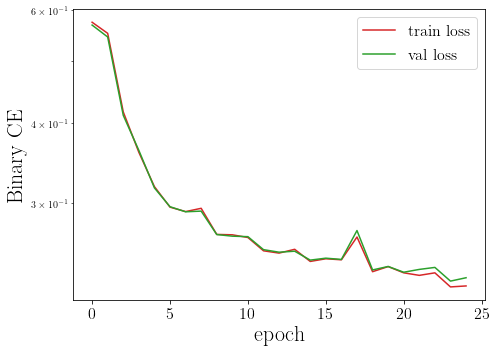

In [590]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Binary CE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

In [591]:
samp_size = 10000

train_pred = model( torch.Tensor( z_train[:samp_size] ) ).detach()
test_pred = model( torch.Tensor( z_test[:samp_size] ) ).detach()
val_pred = model( torch.Tensor( z_val[:samp_size] ) ).detach()

train_pred_lab = torch.round( train_pred[:samp_size] )
test_pred_lab = torch.round( test_pred[:samp_size] )
val_pred_lab = torch.round( val_pred[:samp_size] )

train_correct = ( np.array( train_pred_lab.squeeze(-1) ) == y_train[:samp_size] ).sum()
test_correct = ( np.array( test_pred_lab.squeeze(-1) ) == y_test[:samp_size] ).sum()
val_correct = ( np.array( val_pred_lab.squeeze(-1) ) == y_val[:samp_size] ).sum()

In [592]:
separator()
print('Evaluation of accuracy: ')
print('Accuracy on training dataset: {:.1f} %'.format(train_correct*100/len(train_pred)))
print('Accuracy on validation dataset: {:.1f} %'.format(val_correct*100/len(val_pred)))
print('Accuracy on test dataset: {:.1f} %'.format(test_correct*100/len(test_pred)))
separator()

-----------------------------------------------
Evaluation of accuracy: 
Accuracy on training dataset: 90.6 %
Accuracy on validation dataset: 90.5 %
Accuracy on test dataset: 90.5 %
-----------------------------------------------


In [593]:
from sklearn.metrics import roc_curve, roc_auc_score

def closest_point(array, tpr_p=0.3):
    dist = ((array-tpr_p)**2)
    return np.argmin(dist)

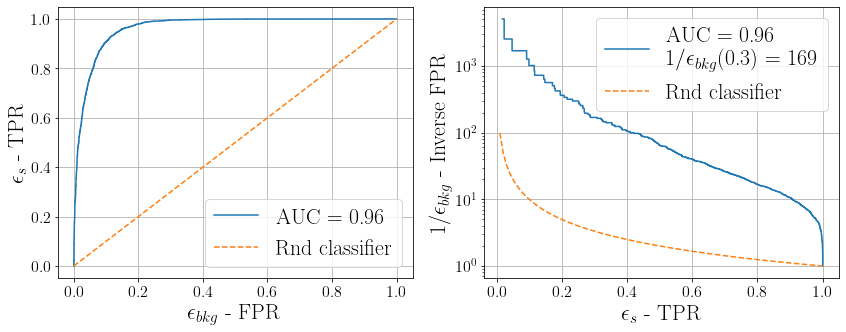

In [594]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(y_test[0:samp_size], test_pred)
auc_score = roc_auc_score(y_test[0:samp_size], test_pred)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

Looks good!